### Загрузка библиотек

In [1]:
import warnings

import matplotlib.pyplot as plt
import numpy as np
import torch
import torchvision
from IPython.display import clear_output
from torch import nn, optim
from torchvision import transforms
from tqdm.auto import tqdm

import os 
import shutil

from collections import defaultdict
import albumentations as A
from albumentations.pytorch import ToTensorV2
import cv2

warnings.filterwarnings("ignore")
%matplotlib inline

C:\anaconda3\Lib\site-packages\albumentations\__init__.py:28: UserWarning: A new version of Albumentations is available: '2.0.6' (you have '2.0.5'). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import clear_output

sns.set_style('whitegrid')
plt.rcParams.update({'font.size': 15})

In [3]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

In [4]:
from torch.utils.data import Dataset, DataLoader

import torch.nn as nn

import torch.nn.functional as F
import torch.optim as optim
from torch import nn

import torchvision.transforms as T
from torchvision.datasets import ImageFolder

from torchvision.models import mobilenet_v3_small
from PIL import Image

from sklearn.model_selection import train_test_split

print(torchvision.__version__)

0.20.1


### 1. Анализ данных

In [5]:
normalize = T.Normalize(mean=[0.485, 0.456, 0.406], 
                        std=[0.229, 0.224, 0.225])

test_transform = T.Compose([
    T.Resize(256),
    T.CenterCrop(224),
    T.ToTensor(),
    normalize,
])

In [24]:
class KaggleDataset1(Dataset):
    SPLIT_RANDOM_SEED = 42
    TEST_SIZE = 0.25

    def __init__(self, root, train=True, load_to_ram=True, transform=None):
        super().__init__()
        self.root = root
        self.train = train
        self.load_to_ram = load_to_ram # подгружать ли датасет в память полностью
        self.transform = transform
        self.to_tensor = T.ToTensor()
        self.all_files = []
        self.all_labels = []
        self.images = []

        self.classes = sorted(os.listdir(self.root))
        for i, class_name in tqdm(enumerate(self.classes), total=len(self.classes)):
            files = sorted(os.listdir(os.path.join(self.root, class_name)))
            train_files, val_files = train_test_split(files, random_state=self.SPLIT_RANDOM_SEED + i,
                                                       test_size=self.TEST_SIZE)
            if self.train:
                self.all_files += train_files
                self.all_labels += [i] * len(train_files)
                if self.load_to_ram:
                    self.images += self._load_images(train_files, i)

            else:
                self.all_files += val_files
                self.all_labels += [i] * len(val_files)
                if self.load_to_ram:
                    self.images += self._load_images(val_files, i)

    def _load_images(self, image_files, label):
        images = []
        for filename in image_files:
            image = Image.open(os.path.join(self.root, self.classes[label], filename)).convert('RGB')
            images += [image]

        return images

    def __len__(self):
        return len(self.all_files)

    def __getitem__(self, item):
        label = self.all_labels[item]
        if self.load_to_ram:
            image = self.images[item]
        else:
            filename = self.all_files[item]
            image = Image.open(os.path.join(self.root, self.classes[label], filename)).convert('RGB')

        if self.transform is not None:
            image = self.transform(image)

        return image, label

In [25]:
class KaggleDataset(Dataset):
    def __init__(self, root, load_to_ram=True, transform=None):
        super().__init__()
        self.root = root
        self.load_to_ram = load_to_ram
        self.transform = transform
        self.to_tensor = T.ToTensor()
        
        self.all_files = sorted([f for f in os.listdir(root) if f.lower().endswith(('.png', '.jpg', '.jpeg'))])

        self.images = []
        if self.load_to_ram:
            for filename in tqdm(self.all_files):
                image = Image.open(os.path.join(self.root, filename)).convert('RGB')
                self.images.append(image)

    def __len__(self):
        return len(self.all_files)

    def __getitem__(self, idx):
        if self.load_to_ram:
            image = self.images[idx]
        else:
            filename = self.all_files[idx]
            image = Image.open(os.path.join(self.root, filename)).convert('RGB')

        if self.transform is not None:
            image = self.transform(image)

        return image, 0

In [27]:
train_dataset = KaggleDataset(root='dl-2025-competition-1/train', load_to_ram=False)

In [8]:
train_dataset.classes

['0',
 '1',
 '10',
 '11',
 '12',
 '13',
 '14',
 '15',
 '16',
 '17',
 '18',
 '19',
 '2',
 '20',
 '21',
 '22',
 '23',
 '24',
 '25',
 '26',
 '27',
 '28',
 '29',
 '3',
 '30',
 '31',
 '32',
 '33',
 '34',
 '35',
 '36',
 '37',
 '38',
 '39',
 '4',
 '40',
 '41',
 '42',
 '43',
 '44',
 '45',
 '46',
 '47',
 '48',
 '49',
 '5',
 '50',
 '51',
 '52',
 '53',
 '54',
 '55',
 '56',
 '57',
 '58',
 '59',
 '6',
 '60',
 '61',
 '62',
 '63',
 '64',
 '65',
 '66',
 '67',
 '68',
 '69',
 '7',
 '70',
 '71',
 '72',
 '73',
 '74',
 '75',
 '76',
 '77',
 '78',
 '79',
 '8',
 '80',
 '81',
 '82',
 '83',
 '84',
 '85',
 '86',
 '87',
 '88',
 '89',
 '9',
 '90',
 '91',
 '92',
 '93',
 '94',
 '95',
 '96',
 '97',
 '98',
 '99']

In [9]:
# все картинки подружены в память
image, label = train_dataset[42]

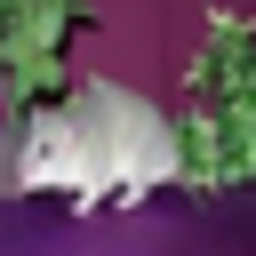

In [10]:
image.resize([item * 8 for item in image.size])

In [11]:
train_dataset.classes[label]

'0'

In [12]:
len(train_dataset)

7097

In [37]:
train_dataset = KaggleDataset1(root='dl-2025-competition-1/train', 
                               load_to_ram=True, transform=test_transform)

  0%|          | 0/100 [00:00<?, ?it/s]

In [14]:
print(f'Число классов: {len(train_dataset.classes)}')

Число классов: 100


In [30]:
test_dataset = KaggleDataset(root='dl-2025-competition-1/test', 
                              load_to_ram=True, transform=test_transform)

  0%|          | 0/3878 [00:00<?, ?it/s]

In [17]:
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, pin_memory=True, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, pin_memory=True, num_workers=4)

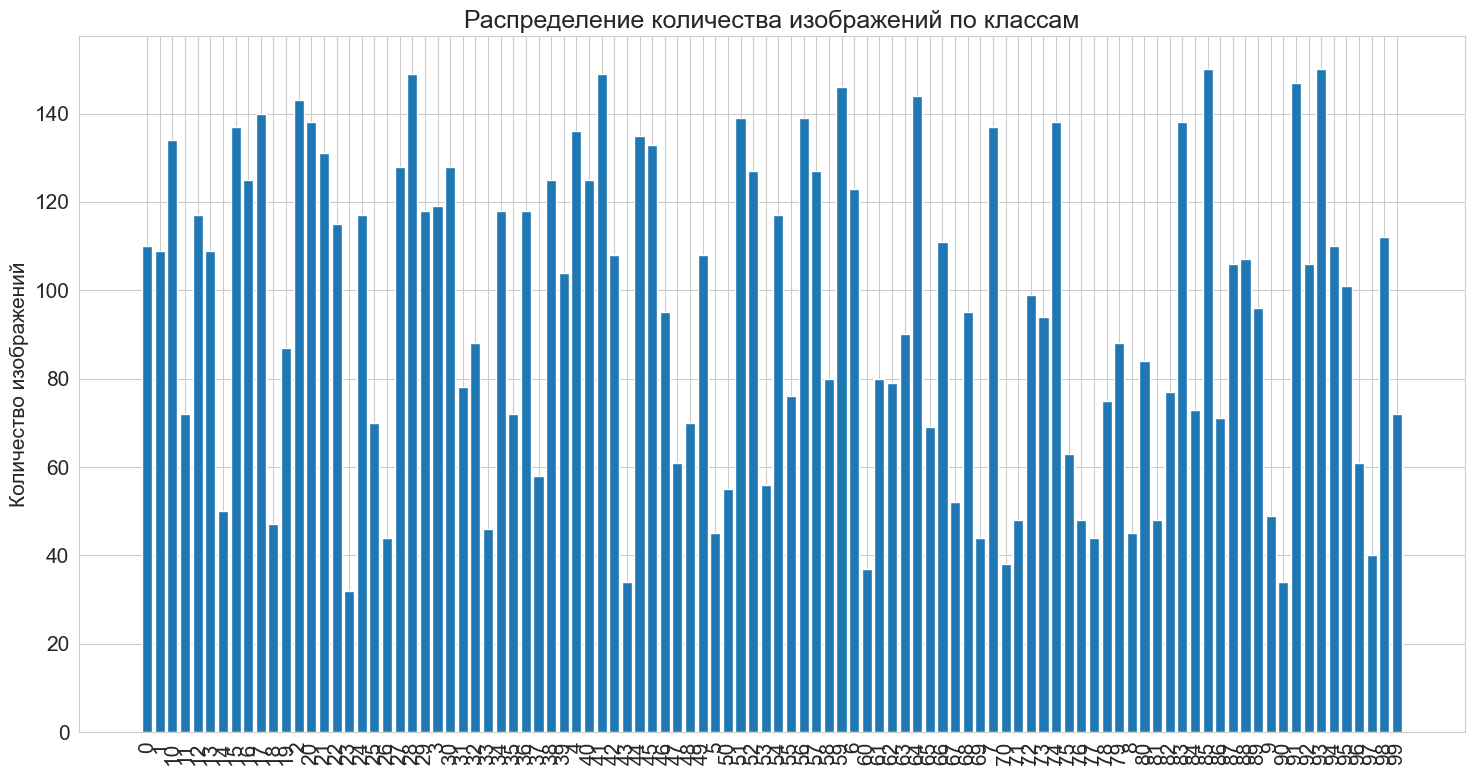

Всего классов: 100
Общее количество изображений: 9510
Минимальное количество изображений в классе: 32
Максимальное количество изображений в классе: 150
Среднее количество изображений на класс: 95.1
Медианное количество изображений на класс: 100.0


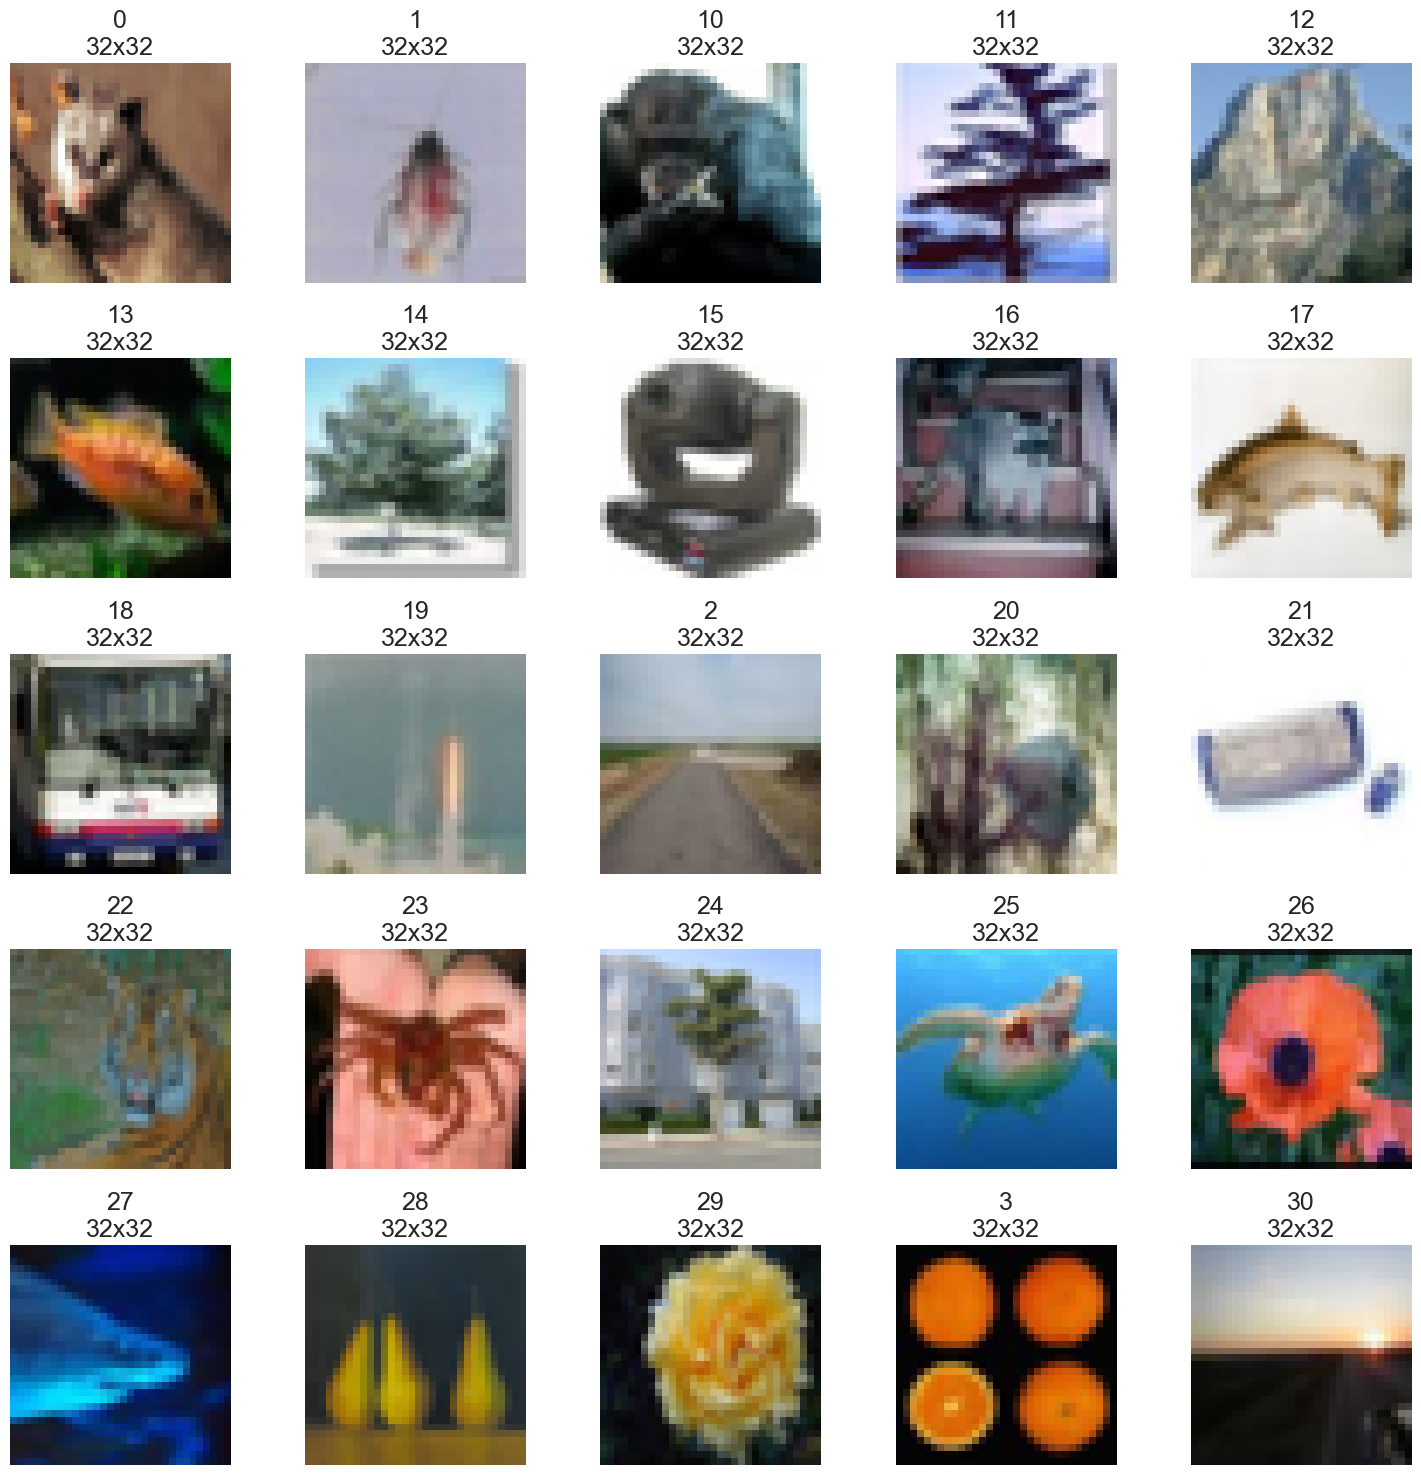

In [18]:
def analyze_dataset(data_path):
    class_counts = defaultdict(int)
    class_examples = {}  # Будем хранить по одному примеру изображения для каждого класса
    
    class_dirs = sorted(os.listdir(data_path))
    for class_dir in class_dirs:
        class_path = os.path.join(data_path, class_dir)
        if os.path.isdir(class_path):
            images = os.listdir(class_path)
            class_counts[class_dir] = len(images)
            
            # Сохраняем пример изображения
            if images and class_dir not in class_examples:
                img_path = os.path.join(class_path, images[0])
                class_examples[class_dir] = img_path
    
    plt.figure(figsize=(15, 8))
    plt.bar(class_counts.keys(), class_counts.values())
    plt.xticks(rotation=90)
    plt.title('Распределение количества изображений по классам')
    plt.ylabel('Количество изображений')
    plt.tight_layout()
    plt.show()
    
    print(f"Всего классов: {len(class_counts)}")
    print(f"Общее количество изображений: {sum(class_counts.values())}")
    print(f"Минимальное количество изображений в классе: {min(class_counts.values())}")
    print(f"Максимальное количество изображений в классе: {max(class_counts.values())}")
    print(f"Среднее количество изображений на класс: {np.mean(list(class_counts.values())):.1f}")
    print(f"Медианное количество изображений на класс: {np.median(list(class_counts.values())):.1f}")
    
    fig, axes = plt.subplots(5, 5, figsize=(15, 15))
    axes = axes.ravel()
    
    for i, (class_name, img_path) in enumerate(list(class_examples.items())[:25]):
        img = Image.open(img_path)
        axes[i].imshow(img)
        axes[i].set_title(f"{class_name}\n{img.size[0]}x{img.size[1]}")
        axes[i].axis('off')
    plt.tight_layout()
    plt.show()
    
    return class_counts

data_path = "C:/Users/Дом/Downloads/dl-2025-competition-1/train"
class_stats = analyze_dataset(data_path)

In [39]:
train_simple_set, val_simple_set = torch.utils.data.random_split(
    train_dataset, [int(0.8 * len(train_dataset)), len(train_dataset) - int(0.8 * len(train_dataset))]
)

In [40]:
train_simple_dataloader = DataLoader(train_simple_set, batch_size=32, shuffle=True, pin_memory=True, num_workers=4)
val_simple_dataloader = DataLoader(val_simple_set, batch_size=256, shuffle=False, pin_memory=True, num_workers=4)

### 2. Albumentations

In [19]:
def get_train_augmentations():
    return A.Compose([
        A.PadIfNeeded(min_height=36, min_width=36, p=1.0),  
        A.RandomCrop(height=32, width=32, p=1.0), 
        A.HorizontalFlip(p=0.5),
        A.VerticalFlip(p=0.2),
        A.Rotate(limit=15, p=0.3),
        A.RandomBrightnessContrast(brightness_limit=0.1, contrast_limit=0.1, p=0.5),
        A.HueSaturationValue(hue_shift_limit=5, sat_shift_limit=10, val_shift_limit=5, p=0.5),
        A.GaussNoise(var_limit=(5.0, 15.0)),
        A.GaussianBlur(blur_limit=(1, 2)),
        A.Normalize(
            mean=[0.485, 0.456, 0.406],
            std=[0.229, 0.224, 0.225]
        ),
        ToTensorV2(),
    ])

def get_valid_augmentations():
    return A.Compose([
        A.Normalize(
            mean=[0.485, 0.456, 0.406],
            std=[0.229, 0.224, 0.225]
        ),
        ToTensorV2(),
    ])

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

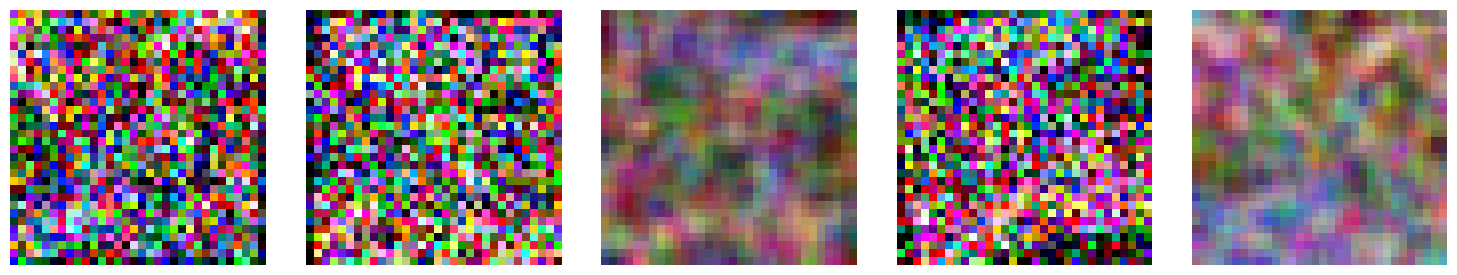

In [20]:
class AlbumentationsDataset(Dataset):
    def __init__(self, root, transform=None, train=True):
        self.dataset = KaggleDataset(root=root, train=train, load_to_ram=True)
        self.transform = transform
        
    def __len__(self):
        return len(self.dataset)
    
    def __getitem__(self, idx):
        image, label = self.dataset[idx]
        
        image = np.array(image)
        
        if self.transform:
            augmented = self.transform(image=image)
            image = augmented['image']
            
        return image, label

train_data = AlbumentationsDataset(
    root='dl-2025-competition-1/train',
    transform=get_train_augmentations(),
    train=True
)

valid_data = AlbumentationsDataset(
    root='dl-2025-competition-1/train',
    transform=get_valid_augmentations(),
    train=False
)

def visualize_augmentations(dataset, idx=0, samples=5):
    dataset.transform = get_train_augmentations()
    fig, axes = plt.subplots(1, samples, figsize=(15, 3))
    
    for i in range(samples):
        image, _ = dataset[idx]
        # Денормализация для отображения
        image = image.permute(1, 2, 0).numpy()
        image = image * [0.229, 0.224, 0.225] + [0.485, 0.456, 0.406]
        image = np.clip(image, 0, 1)
        axes[i].imshow(image)
        axes[i].axis('off')
    
    plt.tight_layout()
    plt.show()

visualize_augmentations(train_data)

### 3. Моя модель

In [41]:
def plot_losses(train_losses, test_losses, train_accuracies, test_accuracies):
    clear_output()
    fig, axs = plt.subplots(1, 2, figsize=(13, 4))
    axs[0].plot(range(1, len(train_losses) + 1), train_losses, label='train')
    axs[0].plot(range(1, len(test_losses) + 1), test_losses, label='test')
    axs[0].set_ylabel('loss')

    axs[1].plot(range(1, len(train_accuracies) + 1), train_accuracies, label='train')
    axs[1].plot(range(1, len(test_accuracies) + 1), test_accuracies, label='test')
    axs[1].set_ylabel('accuracy')

    for ax in axs:
        ax.set_xlabel('epoch')
        ax.legend()

    plt.show()

In [42]:
def training_epoch(model, optimizer, criterion, train_loader, tqdm_desc):
    train_loss, train_accuracy = 0.0, 0.0
    model.train()
    for images, labels in tqdm(train_loader, desc=tqdm_desc):
        images = images.to(device)  # images: batch_size x num_channels x height x width
        labels = labels.to(device)  # labels: batch_size

        optimizer.zero_grad()
        logits = model(images)  # logits: batch_size x num_classes
        loss = criterion(logits, labels)
        loss.backward()
        optimizer.step()

        train_loss += loss.item() * images.shape[0]
        train_accuracy += (logits.argmax(dim=1) == labels).sum().item()
    
    train_loss /= len(train_loader.dataset)
    train_accuracy /= len(train_loader.dataset)
    return train_loss, train_accuracy


@torch.no_grad()
def validation_epoch(model, criterion, test_loader, tqdm_desc):
    test_loss, test_accuracy = 0.0, 0.0
    model.eval()
    for images, labels in tqdm(test_loader, desc=tqdm_desc):
        images = images.to(device)  # images: batch_size x num_channels x height x width
        labels = labels.to(device)  # labels: batch_size
        logits = model(images)  # logits: batch_size x num_classes
        loss = criterion(logits, labels)

        test_loss += loss.item() * images.shape[0]
        test_accuracy += (logits.argmax(dim=1) == labels).sum().item()

    test_loss /= len(test_loader.dataset)
    test_accuracy /= len(test_loader.dataset)
    return test_loss, test_accuracy

    
def train(model, optimizer, scheduler, criterion, train_loader, test_loader, num_epochs):
    train_losses, train_accuracies = [], []
    test_losses, test_accuracies = [], []

    for epoch in range(1, num_epochs + 1):
        train_loss, train_accuracy = training_epoch(
            model, optimizer, criterion, train_loader,
            tqdm_desc=f'Training {epoch}/{num_epochs}'
        )
        test_loss, test_accuracy = validation_epoch(
            model, criterion, test_loader,
            tqdm_desc=f'Validating {epoch}/{num_epochs}'
        )

        if scheduler is not None:
            scheduler.step()

        train_losses += [train_loss]
        train_accuracies += [train_accuracy]
        test_losses += [test_loss]
        test_accuracies += [test_accuracy]
        plot_losses(train_losses, test_losses, train_accuracies, test_accuracies)

    return train_losses, test_losses, train_accuracies, test_accuracies

In [49]:
class CustomCNN(nn.Module):
    def __init__(self, num_classes=100):
        super().__init__()
        
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, 3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2),
            
            nn.Conv2d(64, 128, 3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(2),
            
            nn.Conv2d(128, 256, 3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(2),
            
            nn.Conv2d(256, 512, 3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.AdaptiveAvgPool2d(1)
        )
        self.classifier = nn.Sequential(
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(256, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        return self.classifier(x)


In [52]:
class CustomCNNWithTL(nn.Module):
    def __init__(self, num_classes=100):
        super().__init__()
        self.backbone = models.resnet18(pretrained=True)
        
        for param in self.backbone.parameters():
            param.requires_grad = False
            
        in_features = self.backbone.fc.in_features
        self.backbone.fc = nn.Linear(in_features, num_classes)

    def forward(self, x):
        return self.backbone(x)

# CustomCNN.classifier[1] = torch.nn.Linear(512, len(train_dataset.classes))
# CustomCNN_TL = CustomCNN.to(device)

In [53]:
basic_transform = T.Compose([
    T.RandomHorizontalFlip(),
    T.RandomVerticalFlip(),
    T.ToTensor(),
    T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

advanced_transform = A.Compose([
    A.PadIfNeeded(min_height=36, min_width=36, p=1.0),  
    A.RandomCrop(height=32, width=32, p=1.0), 
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.2),
    A.Rotate(limit=15, p=0.3),
    A.RandomBrightnessContrast(brightness_limit=0.1, contrast_limit=0.1, p=0.5),
    A.HueSaturationValue(hue_shift_limit=5, sat_shift_limit=10, val_shift_limit=5, p=0.5),
    A.GaussNoise(var_limit=(5.0, 15.0)),
    A.GaussianBlur(blur_limit=(1, 2)),
    A.PixelDropout(dropout_prob=0.01, p=0.5),
    A.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
        ),
    
    # A.RandomHorizontalFlip(),
    # A.RandomVerticalFlip(),
    # A.RandomRotation(30),
    # A.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    # A.RandomAffine(degrees=0, translate=(0.1, 0.1)),
    # A.ToTensor(),
    # A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [54]:
def upscale_transform(size=224):
    return T.Compose([
        T.Resize(size),
        T.CenterCrop(size),
        T.ToTensor(),
        T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

In [66]:
from collections import defaultdict, namedtuple

LossInfo = namedtuple(
    "LossInfo", ["full_train_losses", "train_epoch_losses", "eval_epoch_losses"]
)
EPOCHS = 10
LR = 0.001
num_epochs=1
optimizer=torch.optim.SGD(model.parameters(), lr=LR)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, num_epochs)
criterion = torch.nn.CrossEntropyLoss()

In [10]:
model = CustomCNN().to(device)
_ = train(
    model=model,
    num_epochs=1,
    train_loader=train_simple_dataloader,
    test_loader=val_simple_dataloader,
    optimizer=optimizer,
    scheduler=scheduler,
    criterion=criterion
)

NameError: name 'CustomCNN' is not defined

In [ ]:
class SimpleNet(torch.nn.Module):
    def __init__(self, dropout=0.4):
        super().__init__()
        # TODO:
        # Your code here:
        # --------------
        self.batch_norm1 = torch.nn.BatchNorm2d(1)

        self.relu = torch.nn.ReLU()

        self.maxpool = torch.nn.MaxPool2d(kernel_size=2)

        self.conv1 = torch.nn.Sequential(
            torch.nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3),
            self.relu,
            self.maxpool,
        )
        self.batch_norm2 = torch.nn.BatchNorm2d(32)

        self.conv2 = torch.nn.Sequential(
            torch.nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3),
            self.relu,
            self.maxpool,
        )

        self.linear1 = torch.nn.Linear(in_features=64 * 5 * 5, out_features=128)
        self.linear2 = torch.nn.Linear(in_features=128, out_features=64)

        self.output = torch.nn.Linear(in_features=64, out_features=10)

        self.dropout = torch.nn.Dropout(p=dropout)

        # --------------
        self.loss_func = torch.nn.CrossEntropyLoss()
        self.targets = torch.Tensor()
        self.preds = torch.Tensor()

    def _forward(self, x):
        # runs the neural network
        # TODO:
        # Your code here
        # --------------
        x = self.batch_norm1(x)
        x = self.conv1(x)

        x = self.batch_norm2(x)
        x = self.conv2(x)

        x = x.view(x.size(0), -1)
        x = self.relu(self.linear1(x))
        x = self.dropout(x)
        x = self.relu(self.linear2(x))

        return self.output(x)
        # --------------

    def forward(self, images, target=None):
        # images ~ (batch size, num channels, height, width)
        # target ~ (batch size)
        # output ~ (batch size, num classes)
        output = self._forward(images)

        # get accuracy score and save it to self.accuracy
        if target is not None:
            loss = self.loss_func(output, target)

            self.targets = torch.cat((self.targets, target.cpu()), 0)
            pred = torch.argmax(output, dim=-1)
            self.preds = torch.cat((self.preds, pred.cpu()), 0)
            self.accuracy = accuracy(self.preds.long(), self.targets.long())

        return loss

    def get_accuracy(self, reset=False):
        # return accuracy by all values till now
        if reset:
            self.targets = torch.Tensor()
            self.preds = torch.Tensor()
        return self.accuracy

### GAN

In [21]:
class Generator(nn.Module):
    def __init__(self, latent_dim=100, feature_map_size=64, img_channels=3):
        super(Generator, self).__init__()
        self.model = nn.Sequential(

            nn.ConvTranspose2d(latent_dim, feature_map_size * 8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(feature_map_size * 8),
            nn.ReLU(True),

            nn.ConvTranspose2d(feature_map_size * 8, feature_map_size * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(feature_map_size * 4),
            nn.ReLU(True),

            nn.ConvTranspose2d(feature_map_size * 4, feature_map_size * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(feature_map_size * 2),
            nn.ReLU(True),

            nn.ConvTranspose2d(feature_map_size * 2, feature_map_size, 4, 2, 1, bias=False),
            nn.BatchNorm2d(feature_map_size),
            nn.ReLU(True),

            nn.ConvTranspose2d(feature_map_size, img_channels, 4, 2, 1, bias=False),
            nn.Tanh()
        )

    def forward(self, z):
        z = z.view(z.size(0), z.size(1), 1, 1)
        return self.model(z)

class Discriminator(nn.Module):
    def __init__(self, feature_map_size=64, img_channels=3):
        super(Discriminator, self).__init__()
        self.model = nn.Sequential(

            nn.Conv2d(img_channels, feature_map_size, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(feature_map_size, feature_map_size * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(feature_map_size * 2),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(feature_map_size * 2, feature_map_size * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(feature_map_size * 4),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(feature_map_size * 4, feature_map_size * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(feature_map_size * 8),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(feature_map_size * 8, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )

    def forward(self, x):
        out = self.model(x)
        return out.view(-1)  

In [22]:
latent_dim = 100
lr = 0.00005
n_discriminator = 1     # количество шагов обучения критика за один шаг обучения генератора
n_generator = 1
clip_value = 0.01
num_epochs = 10 

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

G = Generator(latent_dim=latent_dim).to(device)
D = Discriminator().to(device)

real_label = 1.
fake_label = 0.

optimizer_G = optim.Adam(G.parameters(), lr=0.0002, betas=(0.5, 0.999))
optimizer_D = optim.Adam(D.parameters(), lr=0.0002, betas=(0.5, 0.999))

losses_G = []
losses_D = []

In [23]:
criterion = nn.BCELoss()

In [ ]:
plt.ion()
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

for epoch in tqdm(range(num_epochs)):
    for i, real_images in enumerate(train_loader):
        real_images = real_images.to(device)
        batch_size_curr = real_images.size(0)

        # ---------------------
        #  Train Discriminator
        # ---------------------
        for _ in range(n_discriminator):
            optimizer_D.zero_grad()

            labels_real = torch.full((batch_size_curr,), real_label, device=device)
            output_real = D(real_images).view(-1)
            loss_D_real = criterion(output_real, labels_real)
            loss_D_real.backward()

            noise = torch.randn(batch_size_curr, latent_dim, device=device)
            fake_images = G(noise)
            labels_fake = torch.full((batch_size_curr,), fake_label, device=device)

            output_fake = D(fake_images.detach()).view(-1) 
            loss_D_fake = criterion(output_fake, labels_fake)
            loss_D_fake.backward()

            loss_D = loss_D_real + loss_D_fake
            optimizer_D.step()

        losses_D.append(loss_D.item())

        # ---------------------
        #  Train Generator
        # ---------------------
        for _ in range(n_generator):
            optimizer_G.zero_grad()
            labels_gen = torch.full((batch_size_curr,), real_label, device=device)
            noise = torch.randn(batch_size_curr, latent_dim, device=device)
            fake_images = G(noise)
            
            output_fake_for_G = D(fake_images).view(-1)
            loss_G = criterion(output_fake_for_G, labels_gen)
            loss_G.backward()
            optimizer_G.step()

        losses_G.append(loss_G.item())

        if i % 50 == 0:
            print(f"Epoch [{epoch+1}/{num_epochs}] Batch {i}/{len(_train_loader)}  Loss_D: {loss_D.item():.4f}  Loss_G: {loss_G.item():.4f}")

    ax1.clear()
    ax1.plot(losses_G, label="Generator Loss", color='blue')
    ax1.set_xlabel("Batch #")
    ax1.set_ylabel("Loss G")
    ax1.legend()

    ax2.clear()
    ax2.plot(losses_D, label="Discriminator Loss", color='red')
    ax2.set_xlabel("Batch #")
    ax2.set_ylabel("Loss D")
    ax2.legend()

    plt.suptitle(f"Epoch {epoch+1}/{num_epochs}")
    plt.pause(0.1)

plt.ioff()
plt.show()

  0%|          | 0/10 [00:00<?, ?it/s]

In [ ]:
def denormalize(img_tensor):
    img_tensor = (img_tensor + 1) / 2
    return img_tensor.clamp(0, 1)

real_batch = next(iter(dataloader)).to(device)

noise = torch.randn(real_batch.size(0), latent_dim, device=device)
with torch.no_grad():
    fake_batch = G(noise)

n_display = 8
real_imgs = real_batch[:n_display].cpu()
fake_imgs = fake_batch[:n_display].cpu()

fig, axes = plt.subplots(2, n_display, figsize=(n_display * 2, 4))
for i in range(n_display):
    img = denormalize(real_imgs[i]).permute(1, 2, 0).numpy()
    axes[0, i].imshow(img)
    axes[0, i].axis('off')
    if i == 0:
        axes[0, i].set_title("Реальные котики", fontsize=12)
        
    img_fake = denormalize(fake_imgs[i]).permute(1, 2, 0).numpy()
    axes[1, i].imshow(img_fake)
    axes[1, i].axis('off')
    if i == 0:
        axes[1, i].set_title("Сгенерированные котики", fontsize=12)

plt.tight_layout()
plt.show()

In [ ]:
# попробуем немного поменять параметры
from torch.optim.lr_scheduler import StepLR

latent_dim = 300
lr = 0.00003
n_discriminator = 1     # количество шагов обучения критика за один шаг обучения генератора
n_generator = 2
num_epochs = 10 

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

G = Generator(latent_dim=latent_dim).to(device)
D = Discriminator().to(device)

real_label = 1.
fake_label = 0.

optimizer_G = optim.Adam(G.parameters(), lr=0.0002, betas=(0.5, 0.999))
optimizer_D = optim.Adam(D.parameters(), lr=0.0002, betas=(0.5, 0.999))

scheduler_G = StepLR(optimizer_G, step_size=30, gamma=0.1)
scheduler_D = StepLR(optimizer_D, step_size=30, gamma=0.1)

losses_G = []
losses_D = []
criterion = nn.BCELoss()


In [ ]:
plt.ion()
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

for epoch in tqdm(range(num_epochs)):
    for i, real_images in enumerate(dataloader):
        real_images = real_images.to(device)
        batch_size_curr = real_images.size(0)

        # ---------------------
        #  Train Discriminator
        # ---------------------
        for _ in range(n_discriminator):
            optimizer_D.zero_grad()

            labels_real = torch.full((batch_size_curr,), real_label, device=device)
            output_real = D(real_images).view(-1)
            loss_D_real = criterion(output_real, labels_real)
            loss_D_real.backward()

            noise = torch.randn(batch_size_curr, latent_dim, device=device)
            fake_images = G(noise)
            labels_fake = torch.full((batch_size_curr,), fake_label, device=device)

            output_fake = D(fake_images.detach()).view(-1) 
            loss_D_fake = criterion(output_fake, labels_fake)
            loss_D_fake.backward()

            loss_D = loss_D_real + loss_D_fake
            optimizer_D.step()

        losses_D.append(loss_D.item())

        # ---------------------
        #  Train Generator
        # ---------------------
        for _ in range(n_generator):
            optimizer_G.zero_grad()
            labels_gen = torch.full((batch_size_curr,), real_label, device=device)
            noise = torch.randn(batch_size_curr, latent_dim, device=device)
            fake_images = G(noise)
            
            output_fake_for_G = D(fake_images).view(-1)
            loss_G = criterion(output_fake_for_G, labels_gen)
            loss_G.backward()
            optimizer_G.step()

        losses_G.append(loss_G.item())

        if i % 50 == 0:
            print(f"Epoch [{epoch+1}/{num_epochs}] Batch {i}/{len(dataloader)}  Loss_D: {loss_D.item():.4f}  Loss_G: {loss_G.item():.4f}")

    scheduler_G.step()
    scheduler_D.step()
    
    ax1.clear()
    ax1.plot(losses_G, label="Generator Loss", color='blue')
    ax1.set_xlabel("Batch #")
    ax1.set_ylabel("Loss G")
    ax1.legend()

    ax2.clear()
    ax2.plot(losses_D, label="Discriminator Loss", color='red')
    ax2.set_xlabel("Batch #")
    ax2.set_ylabel("Loss D")
    ax2.legend()

    plt.suptitle(f"Epoch {epoch+1}/{num_epochs}")
    plt.pause(0.1)

plt.ioff()
plt.show()

In [ ]:
real_batch = next(iter(dataloader)).to(device)

noise = torch.randn(real_batch.size(0), latent_dim, device=device)
with torch.no_grad():
    fake_batch = G(noise)

n_display = 8
real_imgs = real_batch[:n_display].cpu()
fake_imgs = fake_batch[:n_display].cpu()

fig, axes = plt.subplots(2, n_display, figsize=(n_display * 2, 4))
for i in range(n_display):
    img = denormalize(real_imgs[i]).permute(1, 2, 0).numpy()
    axes[0, i].imshow(img)
    axes[0, i].axis('off')
    if i == 0:
        axes[0, i].set_title("Реальные котики", fontsize=12)
        
    img_fake = denormalize(fake_imgs[i]).permute(1, 2, 0).numpy()
    axes[1, i].imshow(img_fake)
    axes[1, i].axis('off')
    if i == 0:
        axes[1, i].set_title("Сгенерированные котики", fontsize=12)

plt.tight_layout()
plt.show()